<a href="https://colab.research.google.com/github/khanmhmdi/Moe-llm-edge-computing/blob/main/DETR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from scipy.optimize import linear_sum_assignment
from torchvision.models._utils import IntermediateLayerGetter



[DETR Facebook Github](https://github.com/facebookresearch/detr.git)

In [3]:
class PositionEmbeddingSine(nn.Module):
    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, x, mask):
        assert mask is not None
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos

class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x

class FrozenBatchNorm2d(torch.nn.Module):
    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias

In [4]:
class BoxUtils(object):
    @staticmethod
    def box_cxcywh_to_xyxy(x):
        x_c, y_c, w, h = x.unbind(-1)
        b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
             (x_c + 0.5 * w), (y_c + 0.5 * h)]
        return torch.stack(b, dim=-1)

    @staticmethod
    def box_xyxy_to_cxcywh(x):
        x0, y0, x1, y1 = x.unbind(-1)
        b = [(x0 + x1) / 2, (y0 + y1) / 2,
             (x1 - x0), (y1 - y0)]
        return torch.stack(b, dim=-1)

    @staticmethod
    def rescale_bboxes(out_bbox, size):
        img_h, img_w = size
        b = BoxUtils.box_cxcywh_to_xyxy(out_bbox)
        b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
        return b

    @staticmethod
    def box_area(boxes):
        """
        Computes the area of a set of bounding boxes, which are specified by its
        (x1, y1, x2, y2) coordinates.
        Arguments:
            boxes (Tensor[N, 4]): boxes for which the area will be computed. They
                are expected to be in (x1, y1, x2, y2) format
        Returns:
            area (Tensor[N]): area for each box
        """
        return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    @staticmethod
    # modified from torchvision to also return the union
    def box_iou(boxes1, boxes2):
        area1 = BoxUtils.box_area(boxes1)
        area2 = BoxUtils.box_area(boxes2)

        lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
        rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

        wh = (rb - lt).clamp(min=0)  # [N,M,2]
        inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

        union = area1[:, None] + area2 - inter

        iou = inter / union
        return iou, union

    @staticmethod
    def generalized_box_iou(boxes1, boxes2):
        """
        Generalized IoU from https://giou.stanford.edu/
        The boxes should be in [x0, y0, x1, y1] format
        Returns a [N, M] pairwise matrix, where N = len(boxes1)
        and M = len(boxes2)
        """
        # degenerate boxes gives inf / nan results
        # so do an early check
        assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
        assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
        iou, union = BoxUtils.box_iou(boxes1, boxes2)

        lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
        rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

        wh = (rb - lt).clamp(min=0)  # [N,M,2]
        area = wh[:, :, 0] * wh[:, :, 1]

        return iou - (area - union) / area

In [5]:
class HungarianMatcher(nn.Module):
    """This class computes an assignment between the targets and the predictions of the network
    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best predictions,
    while the others are un-matched (and thus treated as non-objects).
    """

    def __init__(self, cost_class: float = 1, cost_bbox: float = 1, cost_giou: float = 1):
        """Creates the matcher
        Params:
            cost_class: This is the relative weight of the classification error in the matching cost
            cost_bbox: This is the relative weight of the L1 error of the bounding box coordinates in the matching cost
            cost_giou: This is the relative weight of the giou loss of the bounding box in the matching cost
        """
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """ Performs the matching
        Params:
            outputs: This is a dict that contains at least these entries:
                 "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                 "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates
            targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                 "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
                           objects in the target) containing the class labels
                 "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates
        Returns:
            A list of size batch_size, containing tuples of (index_i, index_j) where:
                - index_i is the indices of the selected predictions (in order)
                - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds:
                len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
        """
        bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        # Compute the giou cost betwen boxes
        cost_giou = -BoxUtils.generalized_box_iou(
            BoxUtils.box_cxcywh_to_xyxy(out_bbox),
            BoxUtils.box_cxcywh_to_xyxy(tgt_bbox)
        )

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

class SetCriterion(nn.Module):
    """ This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
    """
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}
        return losses

    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_boxes):
        """ Compute the cardinality error, ie the absolute error in the number of predicted non-empty boxes
        This is not really a loss, it is intended for logging purposes only. It doesn't propagate gradients
        """
        pred_logits = outputs['pred_logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
        # Count the number of predictions that are NOT "no-object" (which is the last class)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
           The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(BoxUtils.generalized_box_iou(
            BoxUtils.box_cxcywh_to_xyxy(src_boxes),
            BoxUtils.box_cxcywh_to_xyxy(target_boxes))
        )
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        """ This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        return losses

In [6]:
class Backbone(nn.Module):
    """ResNet backbone with frozen BatchNorm."""
    def __init__(self, name: str,
                train_backbone = False,
                pretrained = True,
                return_interm_layers = False,
                dilation = False,
                norm_layer = None,
                hidden_dim = 256):
        super().__init__()
        backbone = getattr(torchvision.models, name)(
            replace_stride_with_dilation = [False, False, dilation],
            pretrained = pretrained,
            norm_layer = norm_layer or FrozenBatchNorm2d
        )
        self.num_channels = 512 if name in ('resnet18', 'resnet34') else 2048

        for name, parameter in backbone.named_parameters():
            if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
        else:
            return_layers = {'layer4': "0"}
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)

        N_steps = hidden_dim // 2
        self.position_embedding = PositionEmbeddingSine(N_steps, normalize=True)

    def forward(self, x, mask = None):
        mask = mask or torch.zeros_like(x[:,0], dtype = torch.bool)
        xs = self.body(x)
        out: Dict[str, NestedTensor] = {}
        for name, x in xs.items():
            m = F.interpolate(mask[None].float(), size=x.shape[-2:]).to(torch.bool)[0]
            pos = self.position_embedding(x, m).to(x.dtype)
            out[name] = (x, m, pos)
        return out[self.body.return_layers["layer4"]]

In [12]:

import math
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from scipy.optimize import linear_sum_assignment
from torchvision.models._utils import IntermediateLayerGetter

# ... [Previous classes PositionEmbeddingSine, MLP, FrozenBatchNorm2d, BoxUtils, HungarianMatcher, SetCriterion, Backbone remain unchanged] ...

class ExpertMLP(nn.Module):
    """MLP with GELU activation for MoE experts to match transformer's original activation"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < self.num_layers - 1:
                x = F.gelu(x)
        return x

class MoE(nn.Module):
    """Mixture of Experts layer with top-k selection"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts, top_k):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.experts = nn.ModuleList([
            ExpertMLP(input_dim, hidden_dim, output_dim, num_layers=2)
            for _ in range(num_experts)
        ])
        self.gate = nn.Linear(input_dim, num_experts)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        seq_len, batch_size, input_dim = x.size()
        x_flat = x.view(-1, input_dim)
        gates = self.softmax(self.gate(x_flat))  # [seq_len*batch, num_experts]

        top_k_gates, top_k_indices = torch.topk(gates, self.top_k, dim=-1)
        top_k_gates = top_k_gates / top_k_gates.sum(dim=-1, keepdim=True)

        expert_outputs = []
        for expert in self.experts:
            expert_outputs.append(expert(x_flat))
        expert_outputs = torch.stack(expert_outputs, dim=1)

        top_k_outputs = expert_outputs[
            torch.arange(expert_outputs.size(0)).unsqueeze(1), top_k_indices
        ]
        weighted_outputs = top_k_gates.unsqueeze(-1) * top_k_outputs
        combined = weighted_outputs.sum(dim=1).view(seq_len, batch_size, -1)
        return combined

class MoETransformerEncoderLayer(nn.Module):
    """Transformer Encoder Layer with MoE"""
    def __init__(self, d_model, nhead, num_experts, top_k, dim_feedforward=2048, dropout=0.1, activation="gelu"):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.moe = MoE(d_model, dim_feedforward, d_model, num_experts, top_k)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        src2 = self.self_attn(src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask
        )[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.moe(src)
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class MoETransformerDecoderLayer(nn.Module):
    """Transformer Decoder Layer with MoE"""
    def __init__(self, d_model, nhead, num_experts, top_k, dim_feedforward=2048, dropout=0.1, activation="gelu"):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.moe = MoE(d_model, dim_feedforward, d_model, num_experts, top_k)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None,**kwargs):
        tgt2 = self.self_attn(tgt, tgt, tgt,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_key_padding_mask
        )[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(tgt, memory, memory,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask
        )[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.moe(tgt)
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class MoETransformer(nn.Module):
    """Transformer with MoE layers"""
    def __init__(self, d_model=256, nhead=8, num_encoder_layers=6, num_decoder_layers=6,
                 num_experts=4, top_k=2, dim_feedforward=2048, dropout=0.1, activation="gelu"):
        super().__init__()
        encoder_layer = MoETransformerEncoderLayer(d_model, nhead, num_experts, top_k,
            dim_feedforward, dropout, activation)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        decoder_layer = MoETransformerDecoderLayer(d_model, nhead, num_experts, top_k,
            dim_feedforward, dropout, activation)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None,
                src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, is_causal=False):
        memory = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                             tgt_key_padding_mask=tgt_key_padding_mask,
                             memory_key_padding_mask=memory_key_padding_mask)
        return output

class DETR(nn.Module):
    """DETR with MoE Transformer"""
    def __init__(self, num_classes, num_queries, backbone=None, transformer=None,
                 num_experts=4, top_k=2):
        super().__init__()
        self.num_queries = num_queries
        if transformer is None:
            self.transformer = MoETransformer(
                d_model=256,
                nhead=8,
                num_encoder_layers=6,
                num_decoder_layers=6,
                num_experts=num_experts,
                top_k=top_k
            )
        else:
            self.transformer = transformer
        hidden_dim = self.transformer.encoder.layers[0].self_attn.embed_dim
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.backbone = backbone or Backbone(
            name="resnet34",
            train_backbone=True,
            pretrained=True,
            return_interm_layers=True,
            hidden_dim=hidden_dim
        )
        self.input_proj = nn.Conv2d(self.backbone.num_channels, hidden_dim, kernel_size=1)

    def forward(self, x):
        features, mask, pos_embed = self.backbone(x)
        src = self.input_proj(features).flatten(2).permute(2, 0, 1)
        pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
        mask = mask.flatten(1)
        query_embed = self.query_embed.weight.unsqueeze(1).repeat(1, x.size(0), 1)
        tgt = torch.zeros_like(query_embed)
        hs = self.transformer(
            src=src + pos_embed,
            tgt=tgt + query_embed,
            src_key_padding_mask=mask,
            memory_key_padding_mask=mask
        )
        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        return {
            'pred_logits': outputs_class.permute(1, 0, 2),
            'pred_boxes': outputs_coord.permute(1, 0, 2)
        }


In [13]:
num_classes = 5
num_queries = 100
model = DETR(num_classes, num_queries, num_experts=8, top_k=2)

matcher = HungarianMatcher(cost_class = 1, cost_bbox = 5, cost_giou = 2)
weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
losses = ['labels', 'boxes', 'cardinality']
criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict, eos_coef=0.1, losses=losses)

In [14]:
imgs = torch.randn((2,3,256,256))
outputs = model(imgs)

In [15]:
targets = [
    {
        "boxes":torch.tensor([[0.1,0.2,0.3,0.6], [0.5,0.6,0.7,0.8]]+[[0.0, 0.0, 1.0, 1.0] for i in range(98)]),
        "labels": torch.tensor([1, 1]+[num_classes for i in range(98)])
    },
    {
        "boxes":torch.tensor([[0.1,0.2,0.3,0.6], [0.5,0.6,0.7,0.8]]+[[0.0, 0.0, 1.0, 1.0] for i in range(98)]),
        "labels": torch.tensor([1, 1]+[num_classes for i in range(98)])
    }
]

In [16]:
losses = criterion(outputs, targets)
sum(losses.values()), losses

(tensor([8.9608], grad_fn=<AddBackward0>),
 {'loss_ce': tensor(1.7356, grad_fn=<NllLoss2DBackward0>),
  'loss_bbox': tensor([2.0335], grad_fn=<DivBackward0>),
  'loss_giou': tensor([1.1917], grad_fn=<DivBackward0>),
  'cardinality_error': tensor(4.)})

In [17]:
class AttentionVisualizer:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.transforms = T.Compose([
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def set_hooks(self, conv_features, enc_attn_weights, dec_attn_weights):
        hooks = [
            model.backbone.body.register_forward_hook(
                lambda self, input, output: conv_features.append(output)
            ),
            model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
                lambda self, input, output: enc_attn_weights.append(output[1])
            ),
            model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
                lambda self, input, output: dec_attn_weights.append(output[1])
            )
        ]
        return hooks

    def compute_features(self, image):
        # use lists to store the outputs via up-values
        conv_features, enc_attn_weights, dec_attn_weights = [], [], []
        # set up hooks
        hooks = self.set_hooks(conv_features, enc_attn_weights, dec_attn_weights)
        with torch.no_grad():
            # propagate through the model
            outputs = self.model(self.transforms(image)[None])
        for hook in hooks:
            hook.remove()
        # don't need the list anymore
        conv_features = conv_features[0]
        enc_attn_weights = enc_attn_weights[0]
        dec_attn_weights = dec_attn_weights[0]
        # get the HxW shape of the feature maps of the CNN
        conv_features = conv_features[self.model.backbone.body.return_layers["layer4"]]
        shape = conv_features.shape[-2:]
        # and reshape the self-attention to a more interpretable shape
        enc_attn_weights = enc_attn_weights.reshape((-1,) + shape + shape)
        dec_attn_weights = dec_attn_weights.reshape((-1, dec_attn_weights.size(1)) + shape)
        boxes, scores = outputs["pred_boxes"][0], outputs["pred_logits"][0].softmax(-1)
        boxes = BoxUtils.rescale_bboxes(boxes, image.shape[-2:])
        return conv_features[0], enc_attn_weights[0], dec_attn_weights[0], boxes, scores

    def visualize_image_with_bboxes(self, ax, image, boxes, scores, loc, query_idx):
        row = int(loc[0] * image.size(1))-1
        col = int(loc[1] * image.size(2))-1
        image = image.permute(1, 2, 0).numpy() # [H,W,C]
        ax.imshow(image)
        ax.add_patch(plt.Circle((row, col), 16, color='r'))
        for idx, (box, score) in enumerate(zip(boxes, scores), start = 1):
            color = 'blue'if idx == query_idx else "red"
            xmin, ymin, xmax, ymax = box
            box = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color =color, linewidth=3)
            ax.add_patch(box)
            ax.text(xmin, ymin, f"{score.max():.2f}", fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
        ax.axis('off')
        ax.set_title("Image")

    def visualize_self_attention(self, ax, sattn, loc, size, sattn_direction = False):
        # convert reference point to absolute coordinates
        row = int(loc[0] * size[0])
        col = int(loc[1] * size[1])
        # compute the downsampling factor for the model
        fact = 2 ** round(math.log2(size[-1] / sattn.shape[-1]))
        # round the position at the downsampling factor
        idx = (row // fact-1, col // fact-1)
        sattn_map = sattn[idx[0], idx[1], ...] if sattn_direction else sattn[..., idx[0], idx[1]]
        ax.imshow(sattn_map, cmap='cividis', interpolation='nearest')
        ax.add_patch(plt.Circle((idx[1],idx[0]), 0.5, color='r'))
        ax.axis('off')
        ax.set_title(f'Self Attention {(row, col)}')

    def visualize_multihead_attention(self, ax, mattn, query_idx):
        ax.imshow(mattn[query_idx-1])
        ax.axis('off')
        ax.set_title(f'Query Id: {query_idx}')

In [18]:
viz = AttentionVisualizer(model)

In [19]:
conv_features, enc_attn_weights, dec_attn_weights, boxes, scores = viz.compute_features(imgs[0])

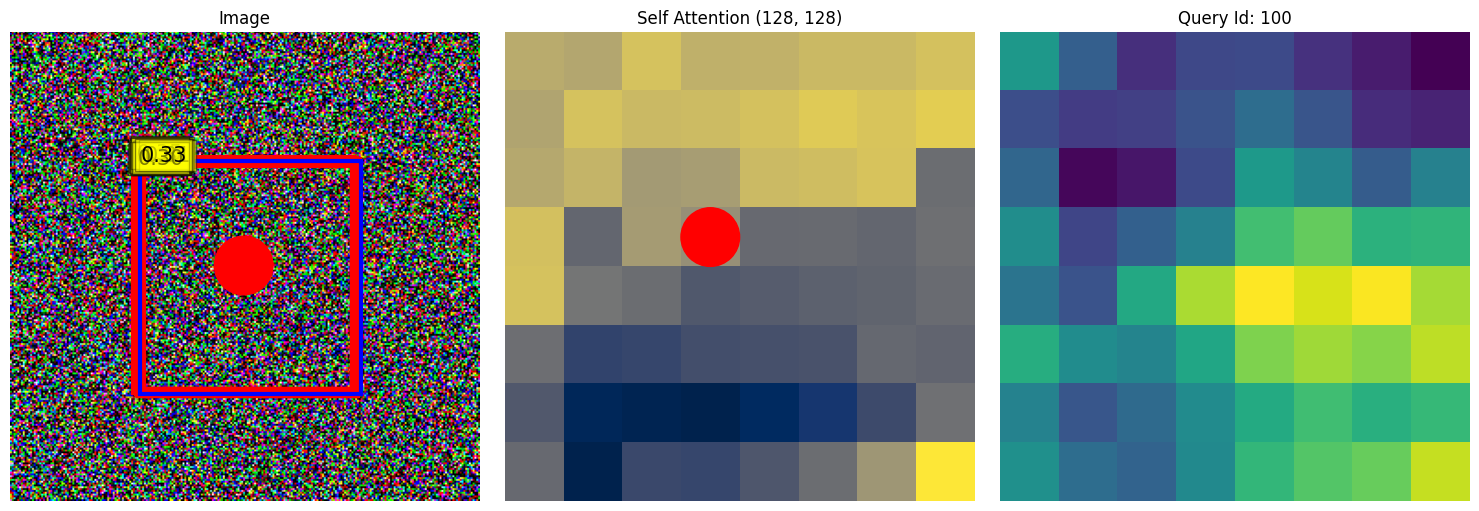

In [20]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(5*3, 5*1), dpi = 100)
loc = (0.5, 0.5); query = 100
viz.visualize_image_with_bboxes(axs[0], imgs[0], boxes, scores, loc, query)
viz.visualize_self_attention(axs[1], enc_attn_weights, loc, (256, 256))
viz.visualize_multihead_attention(axs[2], dec_attn_weights, query)
fig.tight_layout()
plt.show()

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

num_classes = 5
num_queries = 100
model = DETR(num_classes, num_queries, num_experts=8, top_k=2)

total_params = count_parameters(model)
print(f"Total number of parameters: {total_params}")


def count_activated_parameters(model, seq_len, top_k):
    activated_params = 0

    # Transformer parameters (always activated)
    for name, param in model.named_parameters():
        if "moe" not in name:
            activated_params += param.numel()

    # MoE parameters (only top-k experts activated per token)
    for layer in model.transformer.encoder.layers + model.transformer.decoder.layers:
        moe = layer.moe
        expert_params = sum(p.numel() for expert in moe.experts for p in expert.parameters())
        activated_params += seq_len * top_k * expert_params / moe.num_experts

    return activated_params

# Example usage
seq_len = 100  # Number of queries
top_k = 2      # Top-k experts activated per token
activated_params = count_activated_parameters(model, seq_len, top_k)
print(f"Activated parameters during inference: {activated_params}")


import time

# Create a sample input
batch_size = 1
imgs = torch.randn((batch_size, 3, 256, 256))

# Warm-up
for _ in range(10):
    _ = model(imgs)

# Measure FPS
num_runs = 100
start_time = time.time()
for _ in range(num_runs):
    _ = model(imgs)
elapsed_time = time.time() - start_time

fps = num_runs / elapsed_time
print(f"FPS: {fps:.2f}")



Total number of parameters: 127220266
Activated parameters during inference: 2548423114.0


KeyboardInterrupt: 